In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True
)

In [56]:
y2 = np.array(y)

In [57]:
y2

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [89]:
y2[y!='1'] = 0
y2[y=='1'] = 1
y2 = np.array(y2, dtype="int")

In [90]:
n, p = X.shape

7


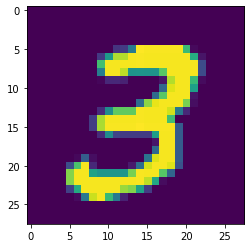

10


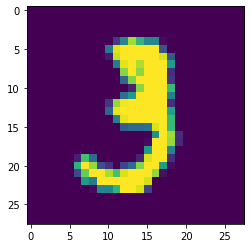

12


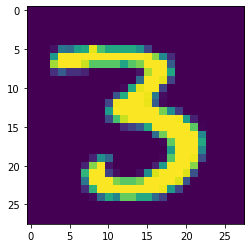

27


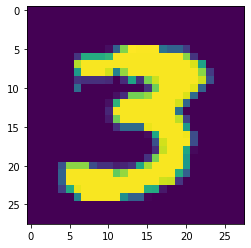

30


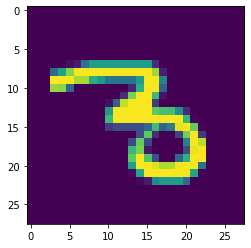

In [91]:
nines = np.where(y == '3')[0]


for j in nines[:5]:
    print(j)
    img = np.array(X.iloc[j,:]).reshape(28,28)

    plt.imshow(img)
    plt.show()

In [92]:
def deep_leakage_from_gradients(model, origin_grad): 
  dummy_data = torch.randn(p)
  dummy_label =  torch.randn(1)#dummy_label.size())
  optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

  for iters in range(300):
    def closure():
      optimizer.zero_grad()
      dummy_pred = model(dummy_data) 
      dummy_loss = criterion(dummy_pred, F.softmax(dummy_label, dim=-1)) 
      dummy_grad = grad(dummy_loss, model.parameters(), create_graph=True)

      grad_diff = sum(((dummy_grad - origin_grad) ** 2).sum() \
        for dummy_g, origin_g in zip(dummy_grad, origin_grad))
      
      grad_diff.backward()
      return grad_diff
    
    optimizer.step(closure)
    
  return  dummy_data, dummy_label

In [102]:
import torch

class MyLogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)     
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [100]:
from sklearn.linear_model import LogisticRegression

lr_sklearn = LogisticRegression(fit_intercept=False)
lr_sklearn.fit(X, y2)

/home/pmangold/.anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(fit_intercept=False)

In [ ]:
lr

In [103]:
lr = MyLogisticRegression(28*28, 1)

In [104]:
lr.linear.weight = torch.nn.Parameter(torch.from_numpy(lr_sklearn.coef_))

In [109]:
Xi, yi = X.iloc[1,:], int(y.iloc[1])
gradi = (Xi@lr_sklearn.coef_.flatten() - yi) * Xi

In [110]:
import torch
deep_leakage_from_gradients(lr, gradi)

RuntimeError: expected scalar type Float but found Double